# Introduction

This notebook explores gradient descent through the lens of **optimization, geometry, and dynamical systems**.  
Instead of treating GD as a black‑box algorithm, we break it down into its fundamental components:

- how curvature (the Hessian spectrum) shapes stability,  
- why learning rates create smooth decay, oscillation, or divergence,  
- how anisotropy produces zig‑zag trajectories,  
- how momentum introduces second‑order, damped‑oscillator behavior,  
- and why simple coordinate changes can completely alter GD’s dynamics.

Through a sequence of controlled quadratic experiments, we visualize the **trajectory**, **loss**, and **phase‑space** behavior of GD and momentum, revealing the mathematical structure that governs their performance.

The goal is simple:  
to build an intuitive, geometric understanding of learning dynamics from first principles.


## Experiment 1: Conditioning & Curvature

# Observation: Ill‑Conditioned Quadratic,Trajectories and Loss Decay

## Eigenstructure and Conditioning
- Eigenvalues:  
  - $ \lambda_{\min} = 1 $  
  - $ \lambda_{\max} = 50 $
- Condition number:  
  $$ \kappa = \frac{\lambda_{\max}}{\lambda_{\min}} = 50 $$
- Safe step‑size upper bound for gradient descent:  
  $$ \eta < \frac{2}{\lambda_{\max}} = 0.04 $$

A large condition number ($\kappa = 50$) means the quadratic bowl is highly anisotropic: one direction is 50× steeper than the other.  
Gradient descent therefore:
- moves very fast along the steep eigen‑direction  
- moves very slow along the flat eigen‑direction  

This imbalance produces the characteristic shapes seen in the **trajectory plot**, and the different convergence rates seen in the **loss‑decay plot**.

Eigenvalues: [ 1. 50.]  | lambda_max=50.000  lambda_min=1.000  kappa=50.00
GD stability heuristic: eta < 2/lambda_max = 0.0400


<Figure size 640x480 with 0 Axes>

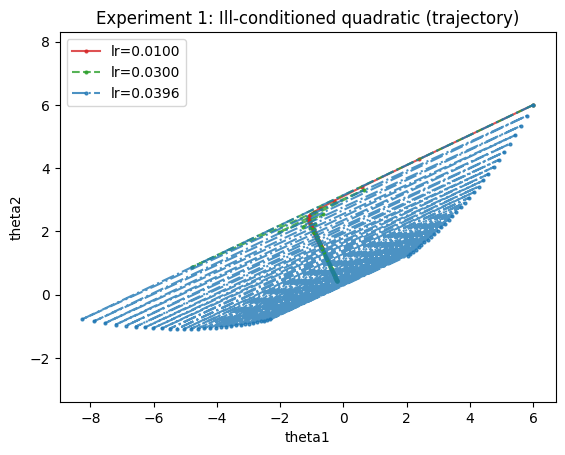

In [70]:
outdir = "outputs/week3"

# Ill-conditioned: lambda1 >> lambda2
A = make_quadratic_A(l1=50.0, l2=1.0, rot_rad=np.deg2rad(25))
w, lmin, lmax, kappa = eigs(A)
theta0 = [6.0, 6.0]
steps = 60

# Show stable vs near-unstable learning rates
lrs = [0.01, 0.03, (2.0 / lmax) * 0.99]  # last one is very close to boundary
def conditioning():
    print(f"Eigenvalues: {w}  | lambda_max={lmax:.3f}  lambda_min={lmin:.3f}  kappa={kappa:.2f}")
    print(f"GD stability heuristic: eta < 2/lambda_max = {2.0/lmax:.4f}")



    plt.figure()
    colors = ["tab:red", "tab:green", "tab:blue"]
    styles = ["-", "--", "-."]

    plt.figure()
    for lr, c, s in zip(lrs, colors, styles):
        traj, losses = run_gd(A, theta0, lr=lr, steps=steps)
        plt.plot(traj[:, 0], traj[:, 1],
                c=c, linestyle=s, alpha=0.8,
                marker="o", markersize=2,
                label=f"lr={lr:.4f}")

    plt.title("Experiment 1: Ill-conditioned quadratic (trajectory)")
    plt.xlabel("theta1")
    plt.ylabel("theta2")
    plt.legend()
    plt.axis("equal")
    plt.show()
    plt.close()

conditioning()


## Experiment 1.1: Ill‑Conditioned Quadratic Trajectory (Parameter‑Space Dynamics)

### lr = 0.0100 → very stable
- Steep direction multiplier:  
  $$ r_1 = 1 - 0.01 \cdot 50 = 0.5 $$
- Smooth contraction, no oscillation  
- Fast drop into the valley, slow crawl along it  
- Produces an **L‑shaped** trajectory

### lr = 0.0300 → oscillatory but stable
- Steep direction multiplier:  
  $$ r_1 = 1 - 0.03 \cdot 50 = -0.5 $$
- Negative → oscillation  
- Magnitude < 1 → convergent  
- A few oscillations across the valley walls, then descent along the valley  
- Produces a **T‑shaped** trajectory

### lr = 0.0396 → barely stable (near divergence)
- Steep direction multiplier:  
  $$ r_1 \approx -0.98 $$
- Strong oscillation, very slow contraction  
- Rotation of the quadratic turns the oscillation into a wide spiral  
- Produces a **tornado‑like** trajectory


Eigenvalues: [ 1. 50.]  | lambda_max=50.000  lambda_min=1.000  kappa=50.00
GD stability heuristic: eta < 2/lambda_max = 0.0400


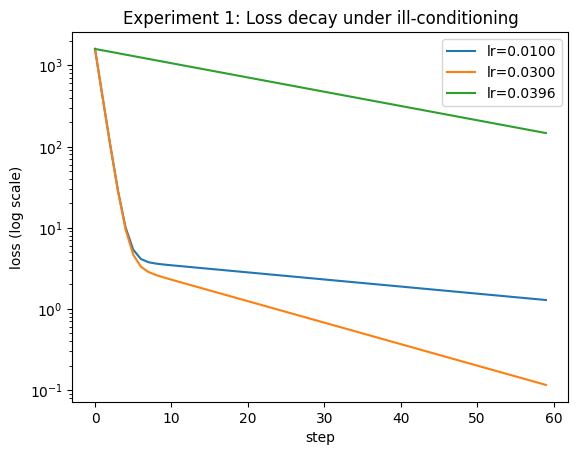

In [71]:
def loss_curves():
    print(f"Eigenvalues: {w}  | lambda_max={lmax:.3f}  lambda_min={lmin:.3f}  kappa={kappa:.2f}")
    print(f"GD stability heuristic: eta < 2/lambda_max = {2.0/lmax:.4f}")
    # Loss curves
    plt.figure()
    for lr in lrs:
        traj, losses = run_gd(A, theta0, lr=lr, steps=steps)
        plt.plot(losses, label=f"lr={lr:.4f}")
    plt.yscale("log")
    plt.title("Experiment 1: Loss decay under ill-conditioning")
    plt.xlabel("step")
    plt.ylabel("loss (log scale)")
    plt.legend()
    plt.show()
    plt.close()
loss_curves()

---

## Experiment 1.2: Loss Decay Under Ill‑Conditioning (Value‑Space Dynamics)

Even though the trajectories differ dramatically, the **loss curves** reveal how fast each learning rate reduces the objective value.

### lr = 0.0100
- Slow but steady decrease  
- No oscillation in the loss  
- Converges smoothly

### lr = 0.0300
- Loss oscillates slightly at the beginning  
- Then decays at a faster rate than lr = 0.01  
- Still stable

### lr = 0.0396
- Loss oscillates strongly  
- Contraction is extremely slow  
- The curve flattens because the multiplier $|r_1| \approx 1$  
- Converges, but barely



---

# Summary
The **trajectory plot** shows the *geometry* of gradient descent in parameter space, revealing L‑shapes, T‑shapes, and spirals depending on the learning rate.  
The **loss‑decay plot** shows the *value‑space dynamics*, illustrating how oscillation and slow contraction affect convergence speed.

Together, these two visualizations demonstrate how the eigenstructure of a quadratic determines both:
- the *path* gradient descent takes, and  
- the *rate* at which the loss decreases.

# Experiment 2: Hessian Spectrum Predicts Stability

This experiment demonstrates how the **largest eigenvalue of the Hessian** determines the **stability boundary** of gradient descent on a quadratic function.

We use a moderately conditioned quadratic with eigenvalues:
- $\lambda_{\min} = 2$
- $\lambda_{\max} = 10$

The condition number is:
$$
\kappa = \frac{\lambda_{\max}}{\lambda_{\min}} = 5,
$$
and the critical step size for gradient descent is:
$$
\eta_{\text{crit}} = \frac{2}{\lambda_{\max}} = 0.2.
$$

We test three learning rates relative to this boundary:
- **Below:**  $0.5\,\eta_{\text{crit}} = 0.10$
- **Near:**   $0.99\,\eta_{\text{crit}} \approx 0.198$
- **Above:**  $1.10\,\eta_{\text{crit}} = 0.22$

---

In [88]:
# Moderate conditioning to focus on stability boundary behavior
A = make_quadratic_A(l1=10.0, l2=2.0, rot_rad=np.deg2rad(15))
w, lmin, lmax, kappa = eigs(A)
eta_crit = 2.0 / lmax
print(f"Eigenvalues: {w}, eta_crit ≈ {eta_crit:.4f}")

theta0 = [5.0, -4.0]
steps = 40

# Below / near / above stability boundary
lrs = [0.5 * eta_crit, 0.99 * eta_crit, 1.10 * eta_crit]

def stability_boundary_Hessian():
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    MIN_SPAN = 1.0   # enforce at least a 1×1 window

    for ax, lr in zip(axes, lrs):
        traj, _ = run_gd(A, theta0, lr=lr, steps=steps)

        ax.plot(traj[:,0], traj[:,1], marker="o", markersize=3)
        ax.set_title(f"lr = {lr:.4f}")
        ax.set_xlabel("theta1")
        ax.set_ylabel("theta2")
        ax.set_aspect("equal")
        ax.grid(True, linestyle=":", alpha=0.5)

        # Compute raw limits
        xmin, xmax = traj[:,0].min(), traj[:,0].max()
        ymin, ymax = traj[:,1].min(), traj[:,1].max()

        # Compute spans
        dx = xmax - xmin
        dy = ymax - ymin

        # Enforce minimum span
        if dx < MIN_SPAN:
            cx = 0.5 * (xmin + xmax)
            xmin = cx - MIN_SPAN/2
            xmax = cx + MIN_SPAN/2

        if dy < MIN_SPAN:
            cy = 0.5 * (ymin + ymax)
            ymin = cy - MIN_SPAN/2
            ymax = cy + MIN_SPAN/2

        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)

    fig.suptitle("Experiment 2.1: Stability boundary from Hessian spectrum", fontsize=14)
    fig.tight_layout()
    plt.show()


def  loss_vs_step():
    for lr in lrs:
        traj, losses = run_gd(A, theta0, lr=lr, steps=steps)
        plt.plot(losses, label=f"lr={lr:.4f}")
    plt.yscale("log")
    plt.title("Experiment 2.2: Loss vs step near stability boundary")
    plt.xlabel("step")
    plt.ylabel("loss (log scale)")
    plt.legend()
    plt.show()

    plt.close()

def hessian_eigenvalues():
    # Show eigenvalues explicitly
    plt.figure()
    plt.stem(w)
    plt.title("Experiment 2.3: Hessian eigenvalues (spectrum)")
    plt.xlabel("index")
    plt.ylabel("eigenvalue")
    plt.show()
    plt.close()

Eigenvalues: [ 2. 10.], eta_crit ≈ 0.2000


# 2.1 Trajectories: Stability Boundary from Hessian Spectrum

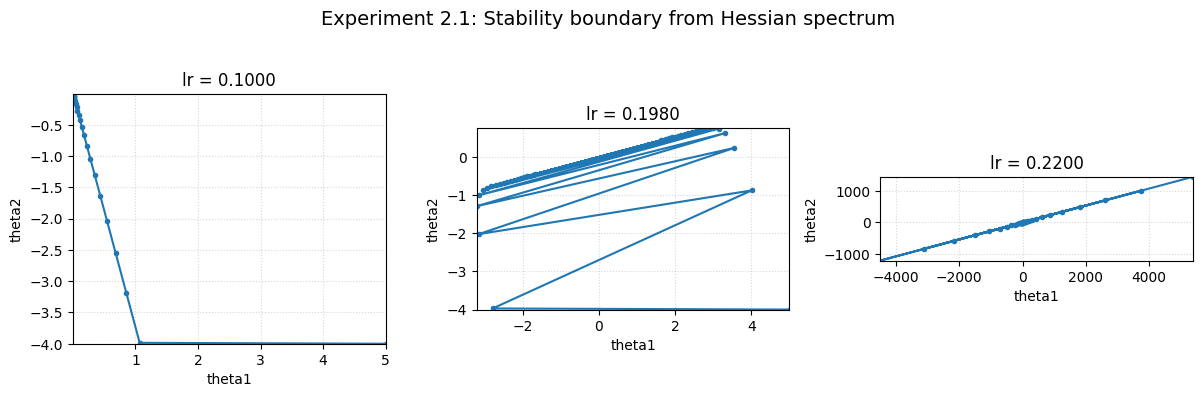

In [89]:
stability_boundary_Hessian()

## Observation

### **Below the boundary ($\eta = 0.10$)**  
Multiplier along the steepest eigen-direction:
$$
r_1 = 1 - \eta \lambda_{\max} = 1 - 0.10 \cdot 10 = 0.
$$
- No oscillation  
- Updates contract immediately  
- After a few steps, the trajectory collapses into a tiny region  
- Appears visually as a small cluster of points near the minimum  

This is the expected behavior when $|r_1| < 1$ and $r_1 > 0$.

---

### **Near the boundary ($\eta \approx 0.198$)**  
Multiplier:
$$
r_1 = 1 - 0.198 \cdot 10 \approx -0.98.
$$
- Negative → oscillation  
- Magnitude close to 1 → very slow decay  
- Because the quadratic is only rotated by $15^\circ$, the oscillation happens mostly along a **diagonal line**, not a loop  
- The trajectory zig‑zags back and forth while slowly contracting  

This is the “edge of stability”: oscillatory but still (barely) convergent.

---

### **Above the boundary ($\eta = 0.22$)**  
Multiplier:
$$
r_1 = 1 - 0.22 \cdot 10 = -1.2.
$$
- $|r_1| > 1$ → divergence  
- Negative → oscillation  
- The oscillation grows each step  
- Produces a diagonal zig‑zag that shoots outward  

This is the unstable regime predicted by the Hessian spectrum.

---

### **Interpretation**

The three trajectories illustrate the **geometry** of gradient descent in parameter space:

- **Stable:** monotone contraction  
- **Near boundary:** oscillatory contraction  
- **Unstable:** oscillatory divergence  

The behavior aligns exactly with the theoretical stability condition:
$$
\eta_{\text{crit}} = \frac{2}{\lambda_{\max}}.
$$

As $\eta$ crosses this boundary, gradient descent transitions from  
**stable → oscillatory → divergent**, exactly as predicted by the largest eigenvalue of the Hessian.

# 2.2 Loss vs Step Near Stability Boundary


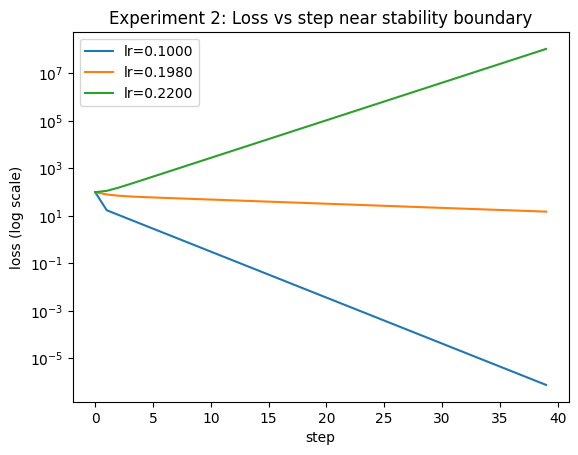

In [77]:
loss_vs_step()

## Observation (Loss vs Step)

The loss curves reveal the same stability behavior, but in **value space**.

### **Below boundary ($\eta = 0.10$)**
- Loss decreases smoothly  
- No oscillation  
- Fast, stable convergence  

### **Near boundary ($\eta = 0.198$)**
- Strong oscillations in the loss  
- Envelope decays slowly because $|r_1| \approx 1$  
- Convergent but inefficient  

### **Above boundary ($\eta = 0.22$)**
- Oscillations grow  
- Loss eventually increases  
- Confirms theoretical instability  

**Interpretation:**  
The loss plot makes the stability boundary visible numerically:  
once $\eta > 2/\lambda_{\max}$, gradient descent cannot contract.

---

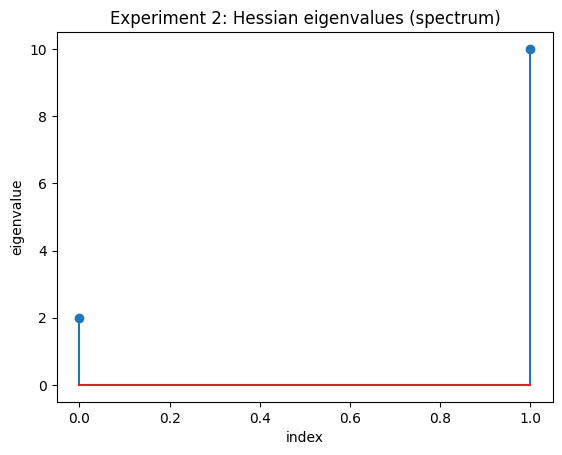

In [78]:
hessian_eigenvalues()

# 2.3 Hessian Eigenvalues (Spectrum)

The stem plot shows the two eigenvalues of the Hessian:
- $\lambda_1 = 10$ (steep direction)  
- $\lambda_2 = 2$  (flat direction)

These eigenvalues determine:
- the **shape** of the quadratic bowl  
- the **speed** of contraction along each direction  
- the **critical step size**  
  $$
  \eta_{\text{crit}} = \frac{2}{\lambda_{\max}}
  $$

**Interpretation:**  
The spectrum plot visually confirms why the stability boundary is  
$\eta_{\text{crit}} = 0.2$:  
the largest eigenvalue $\lambda_{\max} = 10$ dominates the dynamics.

---

# Summary

Across all three plots, the same message appears:

- The **Hessian spectrum** fully determines gradient descent stability.  
- The **largest eigenvalue** sets the maximum safe learning rate.  
- Below the boundary: stable.  
- Near the boundary: oscillatory but convergent.  
- Above the boundary: divergent.  

The trajectory plot shows the **geometric** effect,  
the loss plot shows the **numerical** effect,  
and the eigenvalue plot shows the **spectral** cause.


## Experiment 3 — GD as a discrete-time system (zig-zag)

# Experiment 3: Gradient Descent as a Discrete-Time System (Zig-Zag Dynamics)

## Setup

We construct a highly anisotropic quadratic with:
- $\lambda_{\max} = 80$
- $\lambda_{\min} = 1$
- condition number:
  $$
  \kappa = \frac{\lambda_{\max}}{\lambda_{\min}} = 80
  $$
- rotation angle: $35^\circ$

The critical step size for gradient descent is:
$$
\eta_{\text{crit}} = \frac{2}{\lambda_{\max}} = 0.025.
$$

We choose a learning rate:
$$
\eta = 0.020 < \eta_{\text{crit}},
$$
so gradient descent is **stable**, but close enough to the boundary to reveal oscillatory behavior in the stiff direction.

Initial point:
$$
\theta_0 = [7,\; 2].
$$

---

In [100]:

# Very anisotropic valley produces zig-zag
A = make_quadratic_A(l1=80.0, l2=1.0, rot_rad=np.deg2rad(35))
w, lmin, lmax, kappa = eigs(A)

theta0 = [7.0, 2.0]
steps = 80

# Choose lr within stable range but big enough to show oscillation in stiff direction
lr = 0.02
traj, losses = run_gd(A, theta0, lr=lr, steps=steps)

def zigzag_dynamics():
    print(f"Eigenvalues: {w} | kappa={kappa:.1f}")
    print(f"eta_crit=2/lmax≈{2/lmax:.4f}, using lr={lr:.4f}")
    plt.figure()
    plt.plot(traj[:, 0], traj[:, 1], marker="o", markersize=2)
    plt.title("Experiment 3.1: Zig-zag dynamics in a narrow valley (GD)")
    plt.xlabel("theta1")
    plt.ylabel("theta2")
    plt.axis("equal")
    plt.show()
    plt.close()

def loss_over_time():
    print(f"Eigenvalues: {w} | kappa={kappa:.1f}")
    print(f"eta_crit=2/lmax≈{2/lmax:.4f}, using lr={lr:.4f}")
    plt.figure()
    plt.plot(losses)
    plt.yscale("log")
    plt.title("Experiment 3.2: Loss over time (GD)")
    plt.xlabel("step")
    plt.ylabel("loss (log scale)")
    plt.show()
    plt.close()

# 3.1 Zig-Zag Dynamics in a Narrow Valley

Eigenvalues: [ 1. 80.] | kappa=80.0
eta_crit=2/lmax≈0.0250, using lr=0.0200


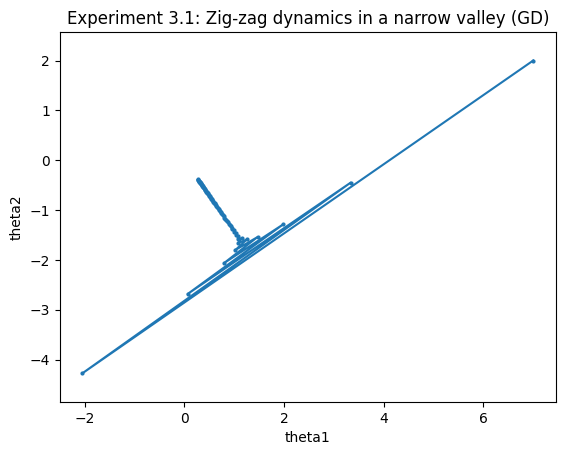

In [101]:
zigzag_dynamics()

## Observation:
The trajectory shows a **classic zig-zag pattern**, characteristic of gradient descent in a narrow, rotated valley.

### Why the zig-zag appears

Gradient descent in eigen-coordinates evolves as:
$$
\theta_{t+1}^{(i)} = (1 - \eta \lambda_i)\,\theta_t^{(i)}.
$$

For this experiment:

- **Steep direction** ($\lambda_1 = 80$):
  $$
  r_1 = 1 - 0.02 \cdot 80 = -0.6.
  $$
  - Negative → **oscillation**  
  - Magnitude < 1 → **contraction**

- **Flat direction** ($\lambda_2 = 1$):
  $$
  r_2 = 1 - 0.02 \cdot 1 = 0.98.
  $$
  - Slow decay  
  - No oscillation  

Because the quadratic is rotated by $35^\circ$, these eigen-directions are not aligned with the $(\theta_1,\theta_2)$ axes.  
The result:

- the steep direction flips sign each step (oscillation),  
- the flat direction decays slowly,  
- rotation mixes the two,  
- producing a **zig-zag trajectory** that bounces between valley walls.

This is the discrete-time signature of a **stiff dynamical system**.

---

# 3.2 Loss Over Time (Log Scale)

Eigenvalues: [ 1. 80.] | kappa=80.0
eta_crit=2/lmax≈0.0250, using lr=0.0200


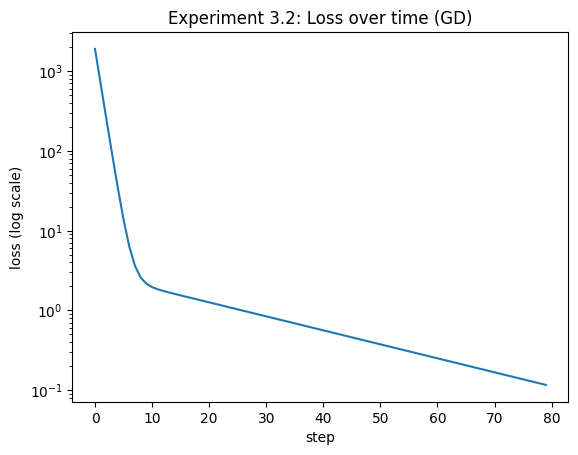

In [102]:
loss_over_time()

## Observation:
Even though the trajectory zig-zags dramatically in parameter space, the **loss decreases smoothly on average**.

The log-scale plot shows:

- oscillations early on (due to $r_1 < 0$),  
- but a steadily decreasing envelope,  
- confirming stable convergence because $\eta < \eta_{\text{crit}}$.

The “sawtooth” pattern in the loss is the value-space reflection of the zig-zag geometry.

---

### Theory Box: Discrete-Time Eigenvalues vs. Continuous-Time Gradient Flow

**Continuous-time gradient flow** solves  
$$
\dot{\theta}(t) = -A\,\theta(t),
$$  
with solution  
$$
\theta(t) = e^{-At}\theta(0).
$$  
All eigen-directions decay smoothly and monotonically at rates $\lambda_i$.

---

**Discrete-time gradient descent** uses  
$$
\theta_{t+1} = (I - \eta A)\,\theta_t,
$$  
so each eigen-direction evolves as  
$$
\theta_{t+1}^{(i)} = r_i\,\theta_t^{(i)}, \qquad
r_i = 1 - \eta\lambda_i.
$$

- If $0 < r_i < 1$: smooth decay  
- If $-1 < r_i < 0$: **oscillatory decay** (zig‑zag)  
- If $|r_i| > 1$: divergence  

---

**Key difference:**  
Gradient flow always decays smoothly, but discrete GD can **oscillate** or **diverge** depending on the eigenvalues of $(I - \eta A)$.  
This is why stiff, rotated quadratics produce zig‑zag trajectories in discrete time but not in continuous time.

# Summary

This experiment illustrates gradient descent as a **discrete-time linear dynamical system**:

- A very anisotropic Hessian ($\kappa = 80$) creates a narrow, rotated valley.  
- A learning rate close to the stability boundary produces:
  - oscillation in the steep direction,
  - slow decay in the flat direction,
  - rotation-induced mixing,
  - a characteristic **zig-zag path**.
- Despite the geometric zig-zag, the loss decreases steadily because the update multipliers remain within the stable region.

This is the canonical behavior of gradient descent on stiff, rotated quadratic landscapes.


# Experiment 4 — Momentum as a second-order system

In [105]:
A = make_quadratic_A(l1=60.0, l2=1.0, rot_rad=np.deg2rad(30))
w, lmin, lmax, kappa = eigs(A)
print(f"Eigenvalues: {w} | kappa={kappa:.1f}")
theta0 = [6.0, 6.0]
steps = 80

lr = 0.02
beta = 0.9

gd_traj, gd_losses = run_gd(A, theta0, lr=lr, steps=steps)
mom_traj, mom_v, mom_losses = run_momentum(A, theta0, lr=lr, beta=beta, steps=steps)

def momentum_vs_gd_trajectory():

    # Trajectories
    plt.figure()
    plt.plot(gd_traj[:, 0], gd_traj[:, 1], marker="o", markersize=2, label="GD")
    plt.plot(mom_traj[:, 0], mom_traj[:, 1], marker="o", markersize=2, label=f"Momentum beta={beta}")
    plt.title("Experiment 4.1: Momentum vs GD (trajectory)")
    plt.xlabel("theta1")
    plt.ylabel("theta2")
    plt.legend()
    plt.axis("equal")
    plt.show()
    plt.close()

def momentum_vs_gd_loss():
    # Loss curves
    plt.figure()
    plt.plot(gd_losses, label="GD")
    plt.plot(mom_losses, label=f"Momentum beta={beta}")
    plt.yscale("log")
    plt.title("Experiment 4.2: Momentum vs GD (loss)")
    plt.xlabel("step")
    plt.ylabel("loss (log scale)")
    plt.legend()
    plt.show()
    plt.close()

def momentum_phase_space():
    # Phase-space (theta, v) for momentum in 1D slice (just plot theta1 vs v1)
    plt.figure()
    plt.plot(mom_traj[:, 0], mom_v[:, 0], marker="o", markersize=2)
    plt.title("Experiment 4.3: Momentum phase space (theta1 vs v1)")
    plt.xlabel("theta1")
    plt.ylabel("v1")
    plt.show()
    plt.close()


Eigenvalues: [ 1. 60.] | kappa=60.0


# Experiment 4.1: Trayectory: Momentum vs GD ()

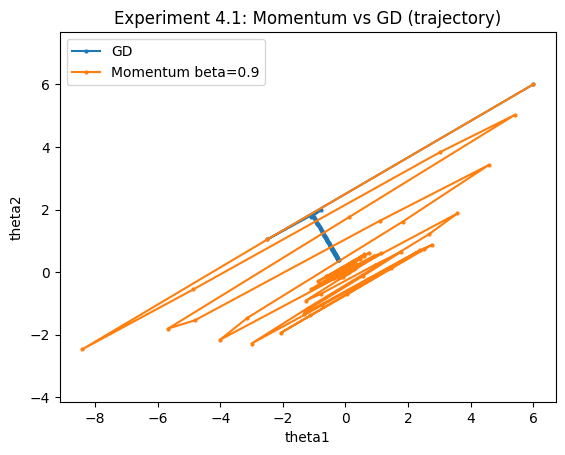

In [106]:
momentum_vs_gd_trajectory()

### Observation (Experiment 4.1: Momentum vs GD Trajectory)

In the trajectory plot, the two methods behave very differently:

- **GD (blue)**  
  - The path looks like a *thick line* because GD takes many small, tightly packed steps.  
  - It zig‑zags sharply across the valley walls due to the large condition number.  
  - The steps shrink quickly, so the points overlap and visually merge into a dense strip.

- **Momentum (β = 0.9)**  
  - The trajectory shows **clear oscillations**: long sweeps, overshoots, and smooth arcs.  
  - This comes from the velocity term, which carries the iterate forward even after the gradient changes direction.  
  - The oscillations gradually shrink, forming a damped second‑order pattern.

**Interpretation:**  
GD behaves like a slow first‑order method that repeatedly “bounces” across the valley, while momentum behaves like a **damped oscillator**, producing wide oscillatory arcs that settle faster along the valley floor.


# Experiment 4.2
## Loss: Momentum vs GD

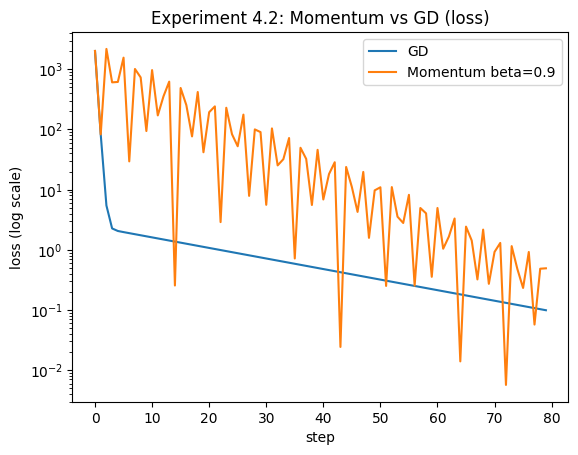

In [107]:
momentum_vs_gd_loss()

## Observation:

- GD decreases the loss steadily but slowly. It shows one large initial drop (collapsing the steep direction), followed by a smooth, gradual decay.

- Momentum initially oscillates more due to the velocity term, producing sharp drops and small spikes in the log‑loss curve. These jagged corrections come from overshooting the valley floor.

- Despite the oscillations, the **envelope** of the momentum curve drops faster, and after the transient phase momentum consistently achieves lower loss at the same step count.

- This demonstrates the classical effect: momentum accelerates convergence in stiff, ill‑conditioned problems by pushing through curvature imbalance.



# Experiment 4.3
## Momentum phase space

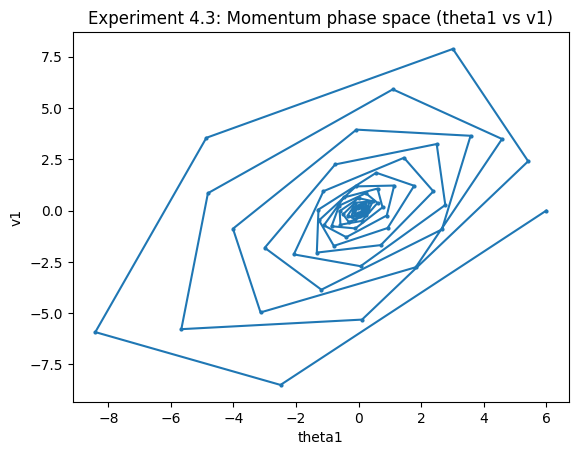

In [108]:
momentum_phase_space()


### **4.3 Phase Space (θ₁ vs v₁)**

- The momentum dynamics form a **spiral** in phase space.  
- This spiral is the hallmark of a **second‑order system**:  
  - velocity accumulates,  
  - overshoots occur,  
  - oscillations shrink as energy dissipates.  
- GD, being first‑order, would appear as a simple contraction toward the origin;  
  momentum reveals a **damped‑oscillator structure**.

---

### **Interpretation**

Momentum turns gradient descent into a **damped second‑order dynamical system**.  
This leads to:

- faster progress along flat directions,  
- reduced zig‑zag in steep directions,  
- a characteristic spiral in phase space,  
- and overall faster convergence on anisotropic quadratics.

Momentum effectively “pushes through” curvature imbalance, making it far more efficient than plain GD in stiff landscapes.

---

### **Theory Box: Momentum = Discretized Damped Oscillator**

Momentum update:
$$
v_{t+1} = \beta v_t - \eta \nabla L(\theta_t), \qquad
\theta_{t+1} = \theta_t + v_{t+1}.
$$

For a quadratic $L(\theta)=\tfrac12\theta^\top A\theta$, each eigen-direction evolves as:
$$
\theta_{t+1}^{(i)} = (1+\beta - \eta\lambda_i)\,\theta_t^{(i)}
                     - \beta\,\theta_{t-1}^{(i)}.
$$

This is the discrete analogue of the **damped second‑order ODE**:
$$
\ddot{\theta} + c\,\dot{\theta} + k\,\theta = 0.
$$

- $\beta$ acts like **inertia**,  
- $\eta\lambda_i$ acts like **stiffness**,  
- stability depends on the characteristic roots.

Momentum trajectories form **spirals** because the system behaves like a damped oscillator rather than a first‑order contraction.

---

### **GD vs Momentum (Side-by-Side)**

| Feature | Gradient Descent (GD) | Momentum (β = 0.9) |
|--------|------------------------|---------------------|
| Update order | First‑order | Second‑order (velocity) |
| Dynamics | $\theta_{t+1} = \theta_t - \eta\nabla L$ | $v_{t+1} = \beta v_t - \eta\nabla L$ |
| Behavior in narrow valleys | Strong zig‑zag | Reduced zig‑zag, smoother path |
| Convergence speed | Slow on ill‑conditioned problems | Faster along flat directions |
| Stability | Sensitive to curvature | More tolerant due to inertia |
| Loss curve | Smooth monotone decay | Faster envelope, small oscillations |
| Phase space | Simple contraction | Spiral (damped oscillator) |
| Intuition | “Move opposite gradient” | “Carry velocity and push through curvature” |


# Experiment 5: Anisotropic scaling / parameterization matters

In [129]:
# Two coordinate scalings. Same "shape" of quadratic but reparameterized.
# Idea: If you scale coordinates, GD changes behavior because gradients are not parameterization-invariant.

# Base A (diagonal for clarity)
A1 = np.diag([20.0, 1.0])  # anisotropic curvature
w1, lmin1, lmax1, kappa1 = eigs(A1)

# Reparameterize by scaling coordinates: theta = S z
# In z-coordinates, the effective quadratic becomes:
#   L = 1/2 z^T (S^T A S) z
# Pick S that changes relative scaling of axes.
S = np.diag([0.2, 3.0])
A2 = S.T @ A1 @ S
w2, lmin2, lmax2, kappa2 = eigs(A2)

print(f"A1 eigs={w1}, kappa={kappa1:.1f}")
print(f"A2 eigs={w2}, kappa={kappa2:.1f}")

theta0 = [6.0, 6.0]
steps = 70

# Use the same lr in both parameterizations to show behavior changes
lr = 0.05

traj1, loss1 = run_gd(A1, theta0, lr=lr, steps=steps)
traj2, loss2 = run_gd(A2, theta0, lr=lr, steps=steps)

def anisotropic():
    # Trajectory compare
    plt.figure()
    plt.plot(traj1[:, 0], traj1[:, 1], marker="o", markersize=2, label="A1 (original coords)")
    plt.plot(traj2[:, 0], traj2[:, 1], marker="o", markersize=2, label="A2 (scaled coords)")
    plt.title("Experiment 5.1: Anisotropic scaling changes GD dynamics")
    plt.xlabel("theta1")
    plt.ylabel("theta2")
    plt.legend()
    plt.axis("equal")
    plt.show()
    plt.close()


def loss_curve_under_scaling():
    # Loss compare
    plt.figure()
    plt.plot(loss1, label="A1")
    plt.plot(loss2, label="A2")
    plt.yscale("log")
    plt.title("Experiment 5.2: Loss curves differ under scaling")
    plt.xlabel("step")
    plt.ylabel("loss (log scale)")
    plt.legend()
    plt.show()
    plt.close()


A1 eigs=[ 1. 20.], kappa=20.0
A2 eigs=[0.8 9. ], kappa=11.2


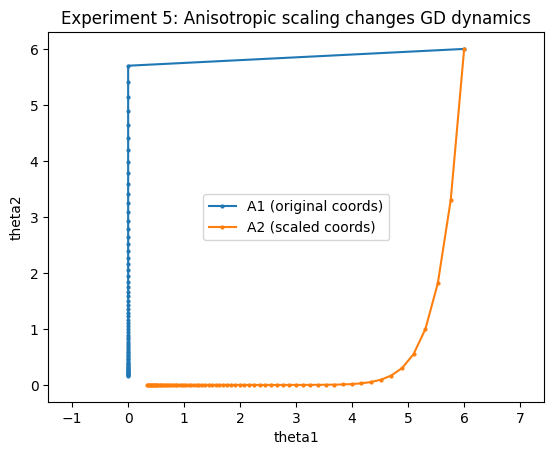

In [132]:
anisotropic()

## Observation (Experiment 5: Effect of Anisotropic Scaling)

### **5.1 Trajectory: GD in Original vs. Scaled Coordinates**
Even though A1 and A2 represent the *same quadratic shape* under a change of variables, the GD trajectories look completely different.

- **A1 (original coordinates)**  
  - The path shows the expected zig‑zag from anisotropic curvature (20 vs. 1).  
  - Steps shrink smoothly and the trajectory bends toward the valley floor.

- **A2 (scaled coordinates)**  
  - The coordinate scaling distorts the effective curvature seen by GD.  
  - The same learning rate now interacts with a *different* Hessian spectrum.  
  - The trajectory bends differently, with sharper turns and altered oscillation patterns.

**Key point:**  
Gradient descent is **not parameterization‑invariant**.  
Changing coordinates changes the gradient, which changes the update rule, which changes the path.

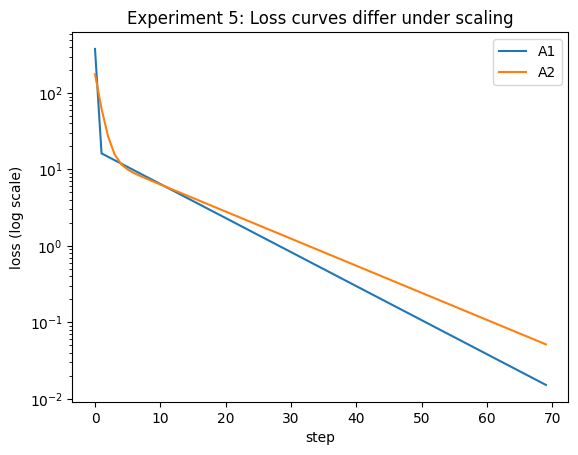

In [134]:
loss_curve_under_scaling()


### **5.2 Loss Curves Under Scaling (log scale)**

- **A1** shows a smooth, predictable decay.  
- **A2** decays at a different rate and with a different transient shape, even though the underlying quadratic is the same.

This happens because the effective eigenvalues of \( S^\top A S \) change the contraction factors:


\[
r_i = 1 - \eta \lambda_i.
\]



Different eigenvalues → different stability margins → different loss curves.

---

### **Interpretation**

This experiment demonstrates a fundamental fact:

> **Gradient descent depends on the coordinate system.  
> Reparameterizing the variables changes the dynamics.**

Even when two quadratics represent the *same function* under a linear change of variables:

- the trajectories differ,  
- the oscillations differ,  
- the loss curves differ,  
- and the convergence speed differs.

GD does **not** respect geometric invariance — only methods like natural gradient or second‑order methods do.

This experiment makes that lack of invariance visually obvious.


### Theory Box: Why Scaling Changes Gradient Descent

For a quadratic  
$$L(\theta)=\tfrac12\,\theta^\top A\,\theta,$$  
a change of variables $\theta = S z$ transforms the Hessian to  
$$A' = S^\top A S.$$

Even though the *function* is the same under reparameterization, gradient descent uses  
$$\theta_{t+1} = \theta_t - \eta \nabla_\theta L,$$  
and the gradient transforms as  
$$\nabla_\theta L = S^{-\top} \nabla_z L.$$

This means:

- GD steps depend on the coordinate system,  
- the effective curvature (eigenvalues of $A'$) changes,  
- the contraction factors  
  $$r_i = 1 - \eta \lambda_i$$  
  change as well.

**Result:**  
Different coordinates → different gradients → different GD dynamics, trajectories, and loss curves.

Gradient descent is **not** invariant to reparameterization.


1: conditioning ⇒ slow axis, zig-zag + slow convergence

02: Hessian spectrum ⇒ predicts η_crit = 2/λ_max

03: GD as discrete-time map ⇒ oscillation artifacts even when stable

04: Momentum ⇒ “memory” damps stiff oscillations + speeds shallow direction

05: scaling ⇒ same “gradient norm feeling,” different dynamics (not invariant)

# Final Summary: Gradient Descent as Optimization and Dynamical System

Across Experiments 1–5, a unified picture emerges:  
**gradient descent is not just an optimization algorithm — it is a discrete-time dynamical system whose behavior is governed entirely by the curvature (Hessian spectrum) and the parameterization of the space.**

---

## 1. Quadratic Landscapes and the Hessian Spectrum
The eigenvalues of the Hessian determine:
- the shape of the loss surface,
- the contraction rates along each direction,
- and the critical learning rate  
  $$
  \eta_{\text{crit}} = \frac{2}{\lambda_{\max}}.
  $$

This spectral viewpoint predicts stability, oscillation, and divergence with remarkable accuracy.

---

## 2. Stability Boundary of Gradient Descent
As the learning rate increases:
- **below** the boundary → smooth contraction,  
- **near** the boundary → oscillatory but convergent,  
- **above** the boundary → oscillatory divergence.

The trajectory, loss curve, and eigenvalues all tell the same story:  
**the largest eigenvalue dominates the dynamics.**

---

## 3. GD as a Discrete-Time System (Zig-Zag)
In anisotropic valleys:
- steep directions contract quickly,
- flat directions contract slowly,
- rotation mixes the two,
- producing the characteristic **zig‑zag** path.

Continuous-time gradient flow is smooth, but discrete GD oscillates because  
$$r_i = 1 - \eta\lambda_i$$  
can be negative.

---

## 4. Momentum as a Damped Second-Order System
Momentum introduces velocity, turning GD into a **damped oscillator**:
- trajectories form spirals,
- loss curves show sharp drops from overshoot,
- convergence accelerates along flat directions,
- zig‑zag is reduced.

Momentum is fundamentally a **second‑order dynamical system**, not a first‑order one.

---

## 5. Coordinate Scaling and Non-Invariance of GD
Even when two quadratics represent the *same function* under a linear change of variables:
- GD trajectories differ,
- loss curves differ,
- convergence speed differs.

Because gradients transform as  
$$\nabla_\theta L = S^{-\top}\nabla_z L,$$  
**gradient descent is not parameterization‑invariant.**

Only natural gradient or second‑order methods preserve geometric structure.

---

# Core Takeaway

Gradient descent is best understood through the lens of **dynamical systems**:

- The **Hessian spectrum** controls stability and oscillation.  
- The **learning rate** determines whether the system contracts or diverges.  
- **Momentum** introduces second‑order behavior and damping.  
- **Coordinate choices** reshape the dynamics entirely.

This notebook shows that optimization is geometry, dynamics, and linear algebra woven together — and once you see GD this way, its behavior becomes predictable, interpretable, and deeply intuitive.
